<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/SCAREDUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


##read data

In [13]:
import gdown
url = 'https://drive.google.com/uc?id=1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8'
#url = "https://drive.google.com/file/d/1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8/view?usp=share_link"
gdown.download(url,'SCARED.zip',quiet=True) 
import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 

In [12]:

rm SCARED.zip

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive') 
sys.path.append('/content/drive/') 

import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q /content/drive/MyDrive/SCARED.zip 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy

import os.path
from os import path
import pandas as pd

# gtpath = "/content/GT/"
# if path.exists(gtpath) == False:
#   os.mkdir(gtpath)

path = "/content/SCARED/"
filelist = []
for root, dirs, files in os.walk(path):
  for file in files:
#         filelist.append(os.path.join(root, file))   #cancatenate folder name with file name
    filelist.append(file)
filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith(".tiff")]
}
print("dataset size: ", len(data["image"]), len(data["depth"]))
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=1)#A random 100% sample, reproducible 1
train = df[:42].reset_index(drop="true")#avoid old index is added as a column, only replace old index with new sequential index is used
valid = df[42:].reset_index(drop="true")
print("table of file names of validation set : \n",valid)
#print(valid.at[0,"depth"], valid["depth"][0])  #the same

dataset size:  48 48
table of file names of validation set : 
                   image                      depth
0  d2k1_Right_Image.png  d2k1_right_depth_map.tiff
1  d1k5_Right_Image.png  d1k5_right_depth_map.tiff
2   d1k5_Left_Image.png   d1k5_left_depth_map.tiff
3   d2k2_Left_Image.png   d2k2_left_depth_map.tiff
4  d5k2_Right_Image.png  d5k2_right_depth_map.tiff
5  d4k4_Right_Image.png  d4k4_right_depth_map.tiff


##prepare dataset

48 42 6
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3, 256])


TypeError: ignored

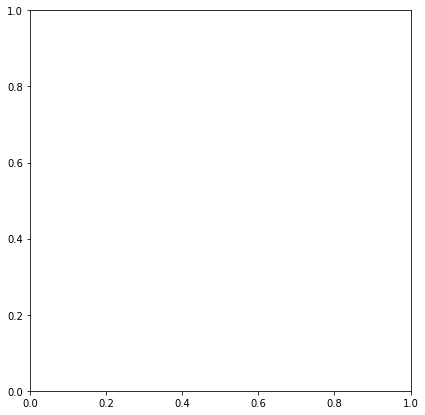

In [5]:
#https://github.com/qiaofengsheng/pytorch-UNet/blob/e9d2ec1f6f7c9336093e71e62b68c1adf5ecdbe0/data.py#L14
from PIL import Image
import tifffile
import numpy as np
import cv2

DIR = "/content/SCARED/"
def keep_image_size_open(path, size=(128, 128)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('P', (temp, temp))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask
def keep_image_size_open_tiff(path, size=(128, 128)):
    img = tifffile.imread(DIR + path)[:,:,2]
    img = np.nan_to_num(img, posinf=0, neginf=0)
    colorimg = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=2.5), cv2.COLORMAP_JET)
    colorimg = Image.fromarray(colorimg)
    temp = max(colorimg.size)
    tiff = Image.new('RGB', (temp, temp))#'P' if grayscale
    tiff.paste(colorimg, (0, 0))
    tiff = tiff.resize(size)
    return tiff
def keep_image_size_open_rgb(path, size=(128, 128)):
    img = Image.open(DIR + path)
    temp = max(img.size)
    image = Image.new('RGB', (temp, temp))
    image.paste(img, (0, 0))
    image = image.resize(size)
    return image

print(len(df),len(train), len(valid))
keep_image_size_open_rgb(train["image"][4]) # ,(1280,1280) if enough RAM
square_tiff = keep_image_size_open_tiff(train["depth"][4] )
#torch.Tensor(np.array(square_tiff))


import os
import numpy as np
import torch
from torch.utils.data import Dataset
#from utils import *
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

class MyDataset(Dataset):
  def __init__(self, data):
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, i):
    depth = keep_image_size_open_tiff(self.data["depth"][i],(32,32))# ,(1280,1280) if enough RAM
    image = keep_image_size_open_rgb(self.data["image"][i],(32,32))
    return transform(image), torch.Tensor(np.array(depth)) #np.array(image), np.array(depth)


from torch.nn.functional import one_hot
d = MyDataset(train)
print(d[0][0].shape)
print(np.transpose(d[0][0],(1,2,0)).shape)
print(d[0][1].shape)
print(d[0][1].long().shape)
print(one_hot(d[0][1].long()).shape)

if d[0][0].shape == (3, 1280, 1280):
  d[0][0] = np.transpose(d[0][0],(1,2,0))
  print("transposed!")
plt.figure(figsize=(15,9))
plt.subplot(121)
plt.imshow(d[0][0])
plt.subplot(122)
plt.imshow(d[0][1])
plt.show()

##net

In [ ]:
#https://zhuanlan.zhihu.com/p/467623152
#https://github.com/milesial/Pytorch-UNet
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        out_channels = [4,8,16,32,64]
        #out_channels = [16,32,64,128,256]
        #out_channels = [40,80,160,320,640]
        #out_channels = [64,128,256,512,1024]
        #out_channels = [80,160,320,640,1280]
        self.inc = DoubleConv(n_channels, out_channels[0])
        self.down1 = Down(out_channels[0], out_channels[1])
        self.down2 = Down(out_channels[1], out_channels[2])
        self.down3 = Down(out_channels[2], out_channels[3])
        self.down4 = Down(out_channels[3], out_channels[4])
        self.up1 = Up(out_channels[4], out_channels[3])
        self.up2 = Up(out_channels[3], out_channels[2])
        self.up3 = Up(out_channels[2], out_channels[1])
        self.up4 = Up(out_channels[1], out_channels[0])
        self.outc = OutConv(out_channels[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

##training

In [ ]:
import os
import tqdm
from torch import nn, optim
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = 'params/unet.pth'
# data_path = r'data'
save_path = 'train_image'


num_classes = 3
data_loader = DataLoader(MyDataset(train), batch_size=1, shuffle=True)
net = UNet(3,num_classes).to(device)
# if os.path.exists(weight_path):
#   net.load_state_dict(torch.load(weight_path))
#   print('successful load weight！')
# else:
#   print('not successful load weight')

!pip -q install torchmetrics
from torchmetrics import StructuralSimilarityIndexMeasure
def ssim(preds, target):
  ssim_loss = StructuralSimilarityIndexMeasure().to(device)(preds, target)
  ssim_loss = torch.mean(1 - ssim_loss)
  return ssim_loss

opt = optim.Adam(net.parameters())
#loss_fun = nn.CrossEntropyLoss()#ssim()


epoch = 1
while epoch < 10:
  for i, (image, depth) in enumerate(tqdm.tqdm(data_loader)):
    depth = np.transpose(depth, (0,3,1,2))#[:,2,:,:]# depth = torch.squeeze(np.transpose(depth, (0,3,1,2), 1)
    image, depth = image.to(device), depth.to(device)#torch.Size([1, 3, 1280, 1280])
    pred = net(image)   #expected input[1, 1280, 1280, 3] to have 3 channels
    #print(image.shape, pred.shape, depth.long().shape)
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 1280, 1280, 3])
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 3, 1280, 1280]) depth transposed
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 1280, 1280]) depth transposed and second dim droped
    train_loss = loss_fun = ssim(pred, depth.long().type(torch.float32))#Expected input batch_size (1) to match target batch_size (3).
    # input pre:(Class), (Nbatch, Class) or (N,C,d_1,d_2,...)
    # target depth:(), (Nbatch,) or (N,d_1,d_2,...)
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    if i % 20 == 0:
        print(f'{epoch}-{i}-train_loss===>>{train_loss.item()}')
  # if epoch % 10 == 0:
  #   torch.save(net.state_dict(), weight_path)
  #   print('save successfully!')
  epoch += 1

In [ ]:
# import random
# import torch
# import time
# import numpy as np
# import torch.optim as optim
# import collections
# import torch.nn as nn

# #test example
# input, target = next(iter(SCAREDDataset(data=valid, batch_size=2)))
# plt.figure(figsize=(15,9))
# for i, j in enumerate([0,3]):
#   plt.subplot(231+j)
#   plt.imshow((input[i] / 255))
#   plt.subplot(232+j)
#   plt.imshow(target[i])
#   plt.subplot(233+j)
#   plt.imshow(cv2.applyColorMap(cv2.convertScaleAbs(target[i], alpha=7.4), cv2.COLORMAP_JET))
# # fig, ax = plt.subplots(2, 2, figsize=(150, 150))
# # for i in range(2):
# #   ax[i, 0].imshow((input[i]))
# #   ax[i, 1].imshow((target[i]), cmap=plt.cm.jet.set_bad(color="black"))

# # dataloaders = {
# #   'train':  SCAREDDataset(data=train, batch_size=2),
# #   'val': SCAREDDataset(data=valid, batch_size=2)
# # }
# # images, depthmaps = dataloaders["val"]
# # for image in images:
# #   image = np.transpose(image,(0,3,1,2))

# # for images, depthmaps in dataloaders['val']:
# #   #for image in images:#(2, 1024, 1280, 3)# channels-last
# #     images = np.transpose(images,(0,3,1,2))

# training_set = SCAREDDataset(data=train, batch_size=2)
# training_iter = iter(SCAREDDataset(data=train, batch_size=2))
# batch = next(training_iter)
# images, depthmaps = batch
# print(training_set, training_iter)  #SCAREDDataset #Iteraotr
# #print(batch)#tuple 4d array
# print(images.shape, depthmaps.shape)#array  #(2, 1024, 1280, 3) (2, 1024, 1280, 3)
# print(images[0].shape)#(1024, 1280, 3)


# #training_set, validation_set = next(iter(SCAREDDataset(data=train, batch_size=2))), next(iter(SCAREDDataset(data=valid, batch_size=2)))
# model  = UNet(3, 1)#first in_channel, n_classes  
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# loss = nn.CrossEntropyLoss()


# final_losses=[]
# t_start = time.time()
# for i in range(3):
#   model.train(mode=True)
#   batch = next(training_iter) 
#   images, depthmaps = batch
#   images = np.transpose(images,(0,3,1,2))
#   depthmaps = np.transpose(depthmaps, (0,3,1,2))
#   print(depthmaps.shape)#(2, 3, 1024, 1280)
#   pred = model(images)
#   loss = loss(pred, depthmaps)
#   final_losses.apend(loss)
#   print("epoch: {}  loss: {}".format(i,loss.item()))
#   optimizer.zero_grad()
#   loss.backward() 
#   optimizer.step()



In [ ]:
# a = np.ones(5)
# b = a.copy()
# print(a)
# for i, j in enumerate([4,5]):
#   a[i,] = j
#   b[i] = j
#   print(i,j)

#   print(a,b,a==b)

In [ ]:
# import numpy as np

# x = np.array([[[0], [1], [2]]])
# print(x.shape,
# np.squeeze(x, axis=-1).shape,
# np.squeeze(x, axis=-1))

# i = np.empty((2, *(1,2), 3))#4D numpy array
# d = np.empty((2, *(1,2), 1))
# print(d)


In [ ]:
# import tensorflow as tf

# # The inputs are 1024x1280 RGB images with 3 `channels_last` and the batch size is 2.
# batch_size = 2
# in_channel = 3
# height, width = 1024, 1280
# out_channel = 320
# kernal_size = 3
# input_shape = (batch_size, height, width, in_channel)#batch size, height, width, channel
# x = tf.random.normal(input_shape)

# y = tf.keras.layers.Conv2D(out_channel, kernal_size, padding="same")(x)# With strides=(1, 1), `padding` as "same".no activation
# print(y.shape)  #(2, 1024, 1280, 320)

# y = tf.keras.layers.MaxPool2D(strides=(2, 2))(x)# strides=(2, 2)
# print(y.shape)  #(2, 512, 640, 3)

In [ ]:
# import torch.nn as nn
# import torch

# # The inputs are 1024x1280 RGB images with 3 `channels_first` and the batch size is 2.
# batch_size = 2
# in_channel = 3
# height, width = 1024, 1280
# out_channel = 320
# kernal_size = 3
# input_size = (batch_size, in_channel, height, width) #batch size, channels_first, height, width
# x = torch.randn(input_size)#x = torch.normal(2, 3, input_shape)#mean, std, size 

# m = nn.Conv2d(in_channel, out_channel, kernal_size, padding=1)(x)# square kernels and with padding
# print(m.shape)#torch.Size([2, 320, 1024, 1280])

# m = nn.MaxPool2d(batch_size)(x)# square kernels and with padding default stride=batch_size
# print(m.shape)#torch.Size([2, 3, 512, 640])

In [ ]:
# def get_config():
#   return dict(
#       net = 'unet',
#       encoder = dict(),
#       data = 'scared', 
#       net_config = dict(),
#       training=dict(
#             batch_size=12,
#             learning_rate=1e-4,
#             epochs=3,
#             mode='pair',
#             loss='ssim',  # other: hamming
#             n_training_steps=500000),  # control time
#       evaluation=dict(batch_size=2),
#       seed = 8
#   )
# config = get_config()
# for (k, v) in config.items():
#   print("{} = {}".format(k, v))#print("%s = %s" % (k, v))#print(f"{k} = {v}")

In [ ]:
seed = config['seed']
random.seed(seed)
np.random.seed(seed + 1)
torch.manual_seed(seed + 2)

In [ ]:
# import tifffile
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# print("image shape: {}  depth shape: {}".format(cv2.imread(path + df.at[37,"image"]).shape, 
#                                                  tifffile.imread(path + df.at[43,"depth"]).shape))
# #WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# image_example1 = cv2.imread(path + df.at[37,"image"])
# image_example2 = cv2.imread(path + df.at[43,"image"])
# depth_example = tifffile.imread(path + df.at[43,"depth"])[:,:,2].astype(np.float32) * 256.0
# depth_example2 = tifffile.imread(path + df.at[43,"depth"]).squeeze().astype(np.float32) 
# colored_depth_example = cv2.applyColorMap(cv2.convertScaleAbs(depth_example, alpha=0.015), cv2.COLORMAP_JET)
# colored_depth_example2 = cv2.applyColorMap(cv2.convertScaleAbs(depth_example2, alpha=7.4), cv2.COLORMAP_JET)
# print("image shape: {}  depth shape: {} / {}".format(image_example1.shape, depth_example.shape, depth_example2.shape))
# plt.figure(figsize=(15,9))
# for i in range(0,6,3):
#   plt.subplot(231+i)
#   plt.imshow(image_example2)
#   #plt.imshow(depth_example2)
#   plt.subplot(232+i)
#   plt.imshow(colored_depth_example)
#   plt.subplot(233+i)
#   plt.imshow(colored_depth_example2)

In [ ]:
# import tifffile
# import numpy as np
# from torch.utils.data import Dataset
# import cv2

# HEIGHT = 1024
# WIDTH = 1280

# class SCAREDDataset(Dataset):
#   def __init__(self, data, batch_size, dim=(HEIGHT,WIDTH), shuffle=True):
#     self.data = data
#     self.batch_size = batch_size
#     self.dim = dim
#     self.id = np.arange(len(data["image"]))

#   def __len__(self):
#     return int(len(self.data))//self.batch_size

#   def __getitem__(self, index):
#     #TODO: if (index+1) > len(data)
#     idx = self.id[index*self.batch_size : (index+1)*self.batch_size]
#     batch = [self.id[i] for i in idx]
#     image, depth = self.generation(batch)
#     return image, depth

#   def generation(self, batch):
#     image = np.empty((self.batch_size, *self.dim, 3))
#     depth = np.empty((self.batch_size, *self.dim, 3))
#     for i, j in enumerate(batch):
#       image[i] = cv2.imread(path+self.data.at[j,"image"])
#       depth[i] = tifffile.imread(path+self.data.at[j,"depth"]).astype(np.float32).squeeze()#or [:,:,2]
#     return image, depth  
#     #TODO: flip = np.random.choicec([True, False])

# #test example
# batch_index = 2 #start from 0
# batch_size = 2
# id = np.arange(len(valid["image"]))
# idx = id[batch_index*batch_size : (batch_index+1)*batch_size]
# batch = [id[i] for i in idx]
# image = np.empty((batch_size, *(1024,1280), 3))
# depth = np.empty((batch_size, *(1024,1280), 3))
# for i, j in enumerate(batch):  #batch:[4, 5] list #idx:[4 5] numpy array
#   image[i] = cv2.imread(path+valid["image"][j])
#   depth[i] = tifffile.imread(path+valid["depth"][j]).astype(np.float32).squeeze()
# print(image.shape, depth.shape)
# plt.imshow(image[0])